In [7]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [8]:

# Load particle tracers
analogTracer = pickle.load(open('data/analogTracer.pkl', 'rb'))
doseEstimatorK = pickle.load(open('data/doseEstimatorK.pkl', 'rb'))[0]
simDomain: LungSimulationDomain = analogTracer.simDomain
simOptions: LungInitialConditions = analogTracer.simOptions
bins = simDomain.xbins
width = simDomain.width

In [9]:
analogTracer.averageNbCollisions

75585.0

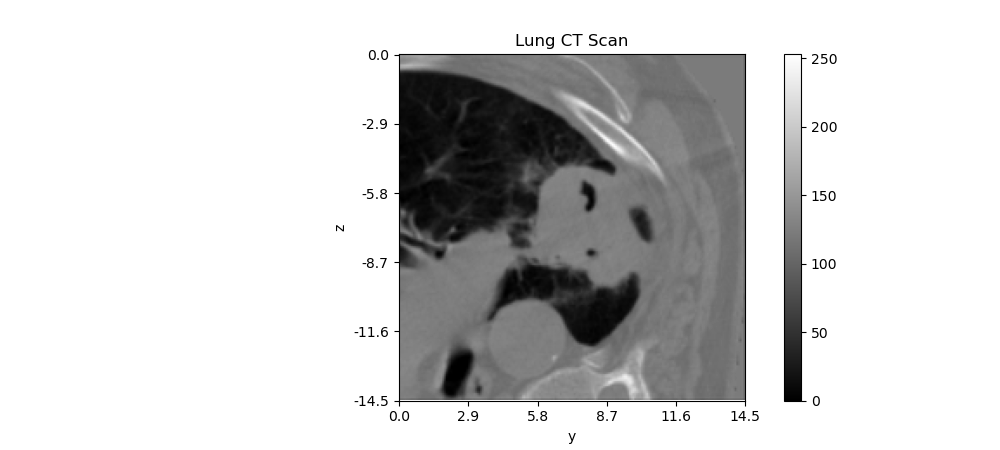

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 4.5))
pos = ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray')  # type: ignore
ax1.set_title('Lung CT Scan')
ax1.set_xlabel('y')
ax1.set_ylabel('z')
nticks = 6
ax1.set_xticks(np.linspace(0, bins, nticks))
ax1.set_xticklabels(np.linspace(0, width, nticks))
ax1.set_yticks(np.linspace(0, bins, nticks))
ax1.set_yticklabels(np.linspace(0, -width, nticks))
fig.colorbar(pos, ax=ax1)


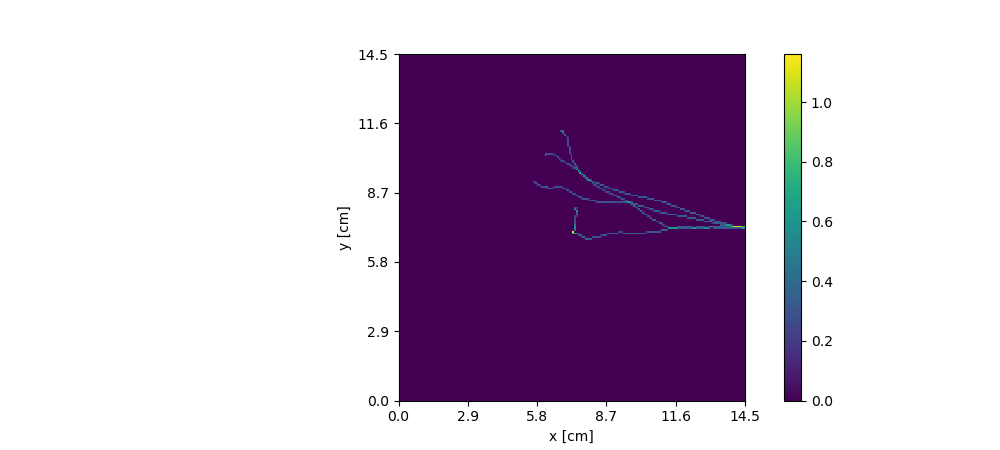

In [11]:
# Plot energy deposition in a subdomain
startIndex = 0; endIndex = bins+1
xBins = np.linspace(0, width, bins+1)
x = xBins[startIndex:endIndex]

energyDepositionK_ERE = np.reshape(doseEstimatorK.scoreMatrix, (bins, bins) )
energyDepositionK_ERE = np.flipud(energyDepositionK_ERE[startIndex:endIndex,startIndex:endIndex])

fig, (ax1) = plt.subplots(figsize=(10, 4.5))

pox = ax1.matshow(energyDepositionK_ERE, extent=[x.min(), x.max(), x.min(), x.max()])
ax1.set_xticks(np.linspace(x.min(), x.max(), nticks))
ax1.set_yticks(np.linspace(x.min(), x.max(), nticks))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
fig.colorbar(pox, ax=ax1)



### Initial direction

In [12]:
testInit = LungInitialConditions()
N = 1000

# Sample a lot of initial vectors
vecs = np.empty((N, 3), dtype=float)
for i in range(N):
    vecs[i, :] = testInit.initialDirection()


(-1.0, 1.0)

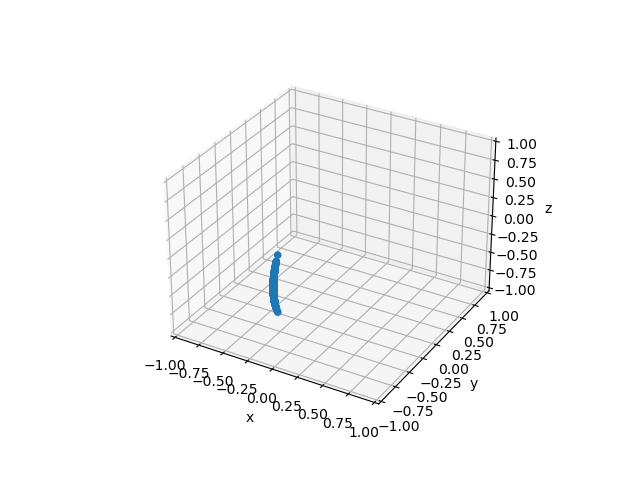

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])